In [269]:
import os
import numpy as np
import pandas as pd

from hitbtc import HitBTC
from aggregate import *
from markup import *
from datetime import datetime

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [340]:
def test(X_test, y_test, y_pred, win_params, slippage=3):
    
    y = np.copy(y_test)

    TP = win_params['TP']
    SL = win_params['SL']
    win_pre = win_params['size_0']
    win_post = win_params['size_1']
    
    # проскальзывание. зависит от объема сделок. возьмем условно
    cost = X_test[:,0].mean()*0.0007 # комиссия биржи. усредненно за тестируемый период
    spread = abs(np.mean(X_test[:,0]-X_test[:,3]))*2
    
    # смотрим, на каких индексах окон происходило закрытие по TimeStop
    idx_TS = np.where(y_test==0)[0]
    # берем индексы свечей открытия и закрытия сделки
    idx_TS_init = idx_TS + win_pre
    idx_TS_close = idx_TS_init + win_post

    idx_TS_init = idx_TS_init[idx_TS_init<X_test.shape[0] - win_post]
    idx_TS_close = idx_TS_close[idx_TS_close<X_test.shape[0]]

    # вычисляем разницу между ценой закрытия и ценой открытия окн
    TS = X_test[idx_TS_init, 0] - X_test[idx_TS_close, 0]
    TS = np.concatenate([TS, np.zeros(y[y_test==0].shape[0] - TS.shape[0])])

    # заменяем коды ответов на результат в пунктах цены,
    # с учетом комиссий и проскальзываний и спредов
    y[y_test==0] = TS - slippage - cost - spread
    y[y_test==1] = TP - slippage - cost #сперда нет, т.к. закрываем лимитным ордером
    y[y_test==2] = -SL - slippage - cost - spread
    # редкий случай, когда в одном баре случается и TP и SL условно примем за худший результат =SL
    y[y_test==3] = -SL - slippage - cost - spread
    # перем ресультаты сделок, предсказанных моделью
    res = y[y_pred==1]
    
    return res

In [385]:
def depo_load(y_pred):

    ret = []
    for i in range(len(y_pred)):
        
        load = y_pred[i:i+win_params['size_1']]
        ret.append(load[load==1].sum()/win_params['size_1'])

    ret = np.array(ret)
    ret = ret[y_pred==1]

    return ret

In [393]:
def report(res, load):
    
    mean_loss_trade = -res[res<0].mean()
    loss_trades = len(res[res<0])
    mean_profit_trade = res[res>=0].mean()
    profit_trades = len(res[res>=0])
    PL = ((profit_trades * mean_profit_trade) / \
          (loss_trades * mean_loss_trade))
    
    plt.figure(figsize=(12,8))
    plt.subplot(211, title='Результат сделок')
    plt.plot(range(len(res)), np.cumsum(res))
    plt.subplot(212, title='Загрузка депозита, %')
    plt.plot(load, c='orange')
    plt.show()
    
    print(f'\nProfit trades: {profit_trades:}\tMean profit trade: {mean_profit_trade:.2f}')
    print(f'Loss trades: {loss_trades}\t\tMean loss trade: {mean_loss_trade:.2f}')
    print(f'\nProfit factor: {PL:.2f}')
    print(f'Mean result on trade: {y.sum()/y.shape[0]:.2f}')

###

In [270]:
### Входные данные
data_path = './data'
file = 'ETHBTC_2020-01-01_2020-04-10_1719370.csv'

# множитель для приведения цены актива к целому значению
point = 1e6

In [271]:
# загрузка данных и приведение типов
df = pd.read_csv(os.path.join(data_path, file))
df = dtypes_corr(df)
# агрегация данных
df = money_repr(df, 100)
df = fill_empty(df)

In [272]:
### Исследуемая модель
clf = GradientBoostingClassifier(random_state=1)

### Исследуемые параметры
clf_params = {
    'max_depth': 1,
    'learning_rate': 0.15,
    'min_samples_split': 200,
    'min_samples_leaf': 92
}

win_params = {
    'TP': 300,
    'SL': 200,
    'size_0': 100,
    'size_1': 50
}

In [274]:
data = window_cutter(df=df, **win_params, point=point)

In [275]:
data.shape

(1947, 601)

In [276]:
X = data[:,:-1]
y = data[:,-1]

In [277]:
# разбиение на трейн тест
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, shuffle=False
)

In [278]:
#  отбор обьектов для обучения
data = np.hstack([
    X_train, 
    y_train.reshape(y_train.shape[0], 1)
])
sel_idx = select(df, data, win_params['size_0'])
X_train = X_train[sel_idx]
y_train = y_train[sel_idx]

In [279]:
clf.set_params(**clf_params)
clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.15, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=92, min_samples_split=200,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [280]:
y_pred = clf.predict(X_test)

**Построение графика доходности и условной загрузки депозита**

In [388]:
# проводим тестирование на полученых результатах
res = test(X_test, y_test, y_pred, win_params)
load = depo_load(y_pred)

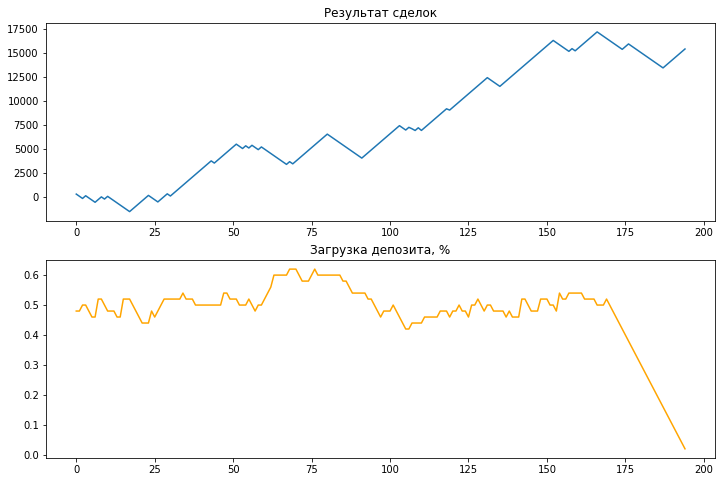


Profit trades: 117	Mean profit trade: 282.03
Loss trades: 78		Mean loss trade: 225.24

Profit factor: 1.88
Mean result on trade: 68.39


In [394]:
report(res, load)